# Cargamos las librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'browser'

2023-06-02 15:35:24.362019: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Cargamos el dataset

In [2]:
# Carga tus datos en un DataFrame
output = pd.read_csv('sstoi.indices.csv')

In [3]:
df = output

In [4]:
dfNO3 = df[['YR M','ON  N','NO3.4']]

In [5]:
dfNO3['Fecha'] = pd.to_datetime({'day' : 1,'month': dfNO3["ON  N"],'year': dfNO3['YR M']}) # Juntar columnas dia, mes y año en formato datetime
dfNO3.set_index('Fecha', inplace=True)
dfNO3 = dfNO3.drop(columns = ["ON  N", 'YR M']) # Quitar columnas Mes y Año
dfNO3

/var/folders/qz/3wk97tbd5mjbmm3vjn79fhvm0000gn/T/ipykernel_57622/683448111.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,NO3.4
Fecha,
1982-01-01,26.65
1982-02-01,26.54
1982-03-01,27.09
1982-04-01,27.83
1982-05-01,28.37
...,...
2022-12-01,25.81
2023-01-01,25.88
2023-02-01,26.29


In [6]:
leng = len(dfNO3)
dfNO3.describe()

,NO3.4
count,496.000000
mean,27.010464
std,0.942563
min,24.560000
25%,26.337500
50%,27.050000
75%,27.682500
max,29.540000


# Preprocesado de los datos

In [7]:
PASOS= 12
salida = 1

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# dataset
values = dfNO3.values
# Normalizar valores
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

# dataframe a aprendizaje supervisado 
reframed = series_to_supervised(scaled, PASOS, salida)
reframed.head()

# Valores de entrada X desde var1(t-12)-var1(t-1)
# Valores de salida Y var1(t)

,var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
12,-0.160643,-0.204819,0.016064,0.313253,0.530120,0.522088,0.208835,0.285141,0.385542,0.582329,0.582329,0.722892,0.662651
13,-0.204819,0.016064,0.313253,0.530120,0.522088,0.208835,0.285141,0.385542,0.582329,0.582329,0.722892,0.662651,0.598394
14,0.016064,0.313253,0.530120,0.522088,0.208835,0.285141,0.385542,0.582329,0.582329,0.722892,0.662651,0.598394,0.562249
15,0.313253,0.530120,0.522088,0.208835,0.285141,0.385542,0.582329,0.582329,0.722892,0.662651,0.598394,0.562249,0.578313
16,0.530120,0.522088,0.208835,0.285141,0.385542,0.582329,0.582329,0.722892,0.662651,0.598394,0.562249,0.578313,0.606426


# Dividimos en set de Entrenamiento y Validación

In [8]:
# Dividir en entrenamiento y testeo
values = reframed.values
n_train_days = leng- (80+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# Input y Output
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]

x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

# 454 entradas con vectores de 1x12
# 454 salidas

(404, 1, 12) (404,) (80, 1, 12) (80,)


# Creamos el Modelo de Red Neuronal
Utilizaremos una FNN

In [9]:
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS+salida-1),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [10]:
EPOCHS=15

model = crear_modeloFF()


history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1, 12)             156       
                                                                 
 flatten (Flatten)           (None, 12)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
34/34 [==============================] - 1s 13ms/step - loss: 0.2989 - mse: 0.1460 - val_loss: 0.2841 - val_mse: 0.1171
Epoch 2/15
34/34 [==============================] - 0s 4ms/step - loss: 0.2493 - mse: 0.0942 - val_loss: 0.2319 - val_mse: 0.0812
Epoch 3/15
34/34 [==============================] - 0s 3ms/st

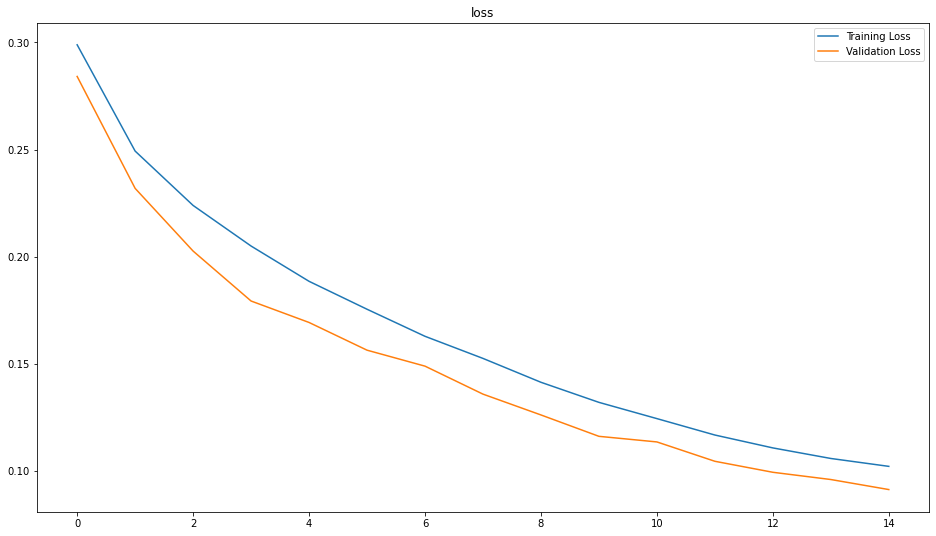

In [11]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.title('loss')
plt.legend()
plt.show()

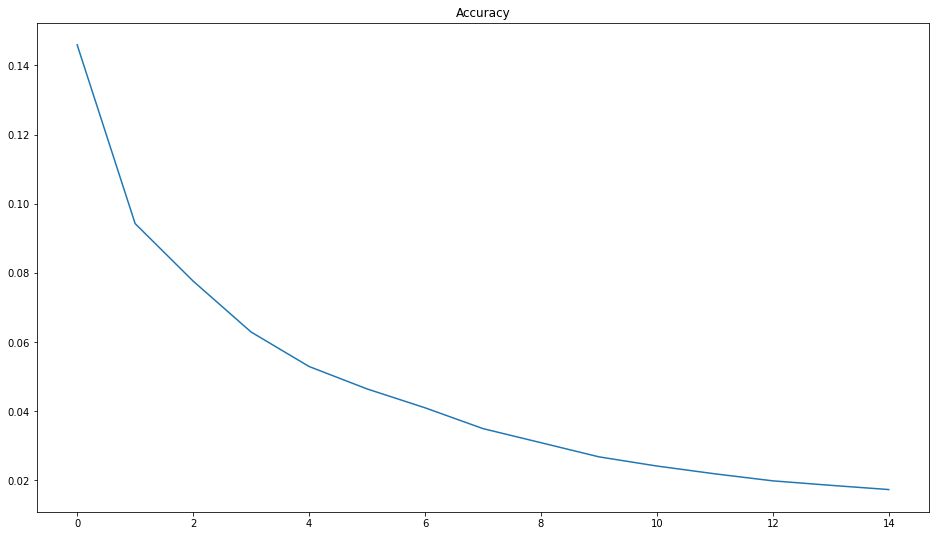

In [18]:
plt.title('Accuracy')
plt.plot(history.history['mse'])
plt.show()

In [13]:
results=model.predict(x_val)
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2

3/3 [==============================] - 0s 3ms/step


,real,prediccion,diferencia
0,26.34,26.467485,-0.127485
1,26.07,26.476974,-0.406974
2,26.18,26.240000,-0.060000
3,26.31,26.238156,0.071844
4,26.30,26.486485,-0.186485
...,...,...,...
75,25.81,25.994293,-0.184293
76,25.88,25.927091,-0.047091
77,26.29,26.111954,0.178046
78,27.23,26.505188,0.724812


In [14]:
compara2.describe()

,real,prediccion,diferencia
count,80.000000,80.000000,80.000000
mean,26.862000,26.847777,0.014223
std,0.829921,0.795884,0.301450
min,25.590000,25.629564,-0.761979
25%,26.067500,26.146957,-0.173519
50%,26.850000,26.844667,-0.005861
75%,27.525000,27.550545,0.163119
max,28.630000,28.598291,0.852171


<AxesSubplot:>

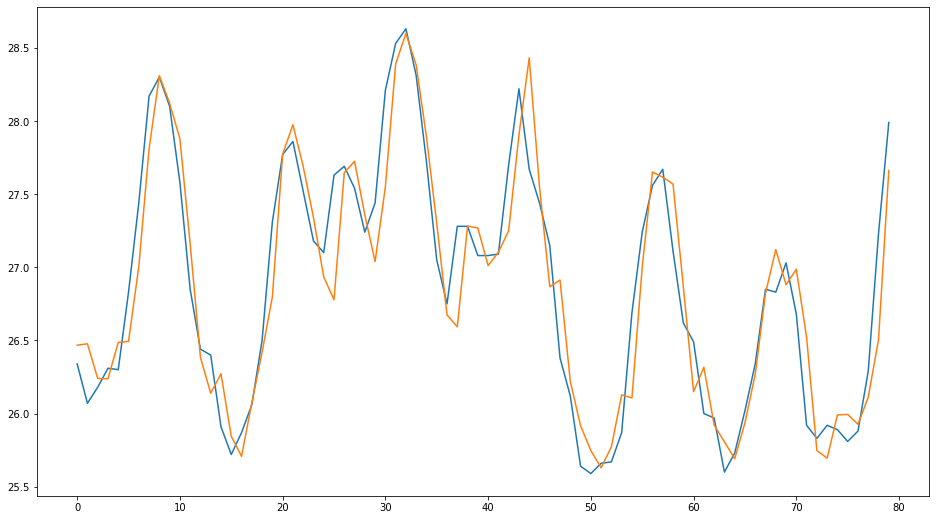

In [15]:
compara2['real'].plot()
compara2['prediccion'].plot()

In [16]:
xtrain = dfNO3.iloc[:n_train_days, :]
xtest = dfNO3.iloc[n_train_days:, :]

In [17]:
fig = go.Figure()
fig.add_trace(go.Scatter(x= xtrain.index, y=xtrain['NO3.4'], mode='lines', name='Datos de entrenamiento'))
fig.add_trace(go.Scatter(x= xtest.index, y=compara2['real'], mode='lines', name='Datos reales'))
fig.add_trace(go.Scatter(x= xtest.index, y=compara2['prediccion'], mode='lines', name='Predicciones Red Neuronal'))
fig.show()